In [ ]:
!pip install diffusers
!pip install opencv_contrib_python
!pip install transformers==3.2.0
!pip install argparse
!pip install freetype-py
!pip install requests
!pip install jsonlines
!pip install tqdm
!pip install pyyaml
!pip install easydict
!pip install timm

  Using cached transformers-3.2.0-py3-none-any.whl.metadata (28 kB)
  Using cached tokenizers-0.8.1rc2.tar.gz (97 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached sacremoses-0.1.1-py3-none-any.whl.metadata (8.3 kB)
Using cached transformers-3.2.0-py3-none-any.whl (1.0 MB)
Using cached sacremoses-0.1.1-py3-none-any.whl (897 kB)
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (tokenizers)
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


Traceback (most recent call last):
  File "<frozen importlib._bootstrap_external>", line 153, in _path_is_mode_type
  File "<frozen importlib._bootstrap_external>", line 147, in _path_stat
FileNotFoundError: [Errno 2] No such file or directory: '/usr/local/lib/python3.10/dist-packages/mpl_toolkits/__init__.so'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 324, in run
    session = self.get_default_session(options)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/index_command.py", line 71, in get_default_session
    self._session = self.enter_

# Diffusion model - Model sinh ảnh

In [1]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

#Load fine-tune Unet_stable-diffusion model
model_id = "wanhin/text2poster"

pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe = pipe.to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/712 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/912 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

# Layout_distribution_predict - Dự đoán phân phối bố cục

In [2]:
!git clone https://github.com/chuhaojin/Text2Poster-ICASSP-22.git
%cd /content/Text2Poster-ICASSP-22

Cloning into 'Text2Poster-ICASSP-22'...
remote: Enumerating objects: 658, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 658 (delta 65), reused 116 (delta 31), pack-reused 493 (from 1)
Receiving objects: 100% (658/658), 51.99 MiB | 16.51 MiB/s, done.
Resolving deltas: 100% (162/162), done.
Updating files: 100% (220/220), done.
/content/Text2Poster-ICASSP-22


In [3]:
# here put the import lib

import torch
import cv2
import os
import numpy as np
from model.distrib_model import LayoutsDistribModel
from utils.anchor_utils import get_candidates_region, get_text_region

scale_val = 20
channel_deep = 16
position_deep = 8
STD_WIDTH, STD_HEIGHT = 300, 400
channel_deep = 16
MIN_VALUE = -999999
MAX_BBOX_NUM = 32

distrib_model = LayoutsDistribModel(
    dim_feedforward = channel_deep,
    scale_val = scale_val,
    channel_deep = channel_deep,
    position_deep = position_deep)

ckpt_path = "./checkpoint/27.80619_distribCNN_BigPosition_epoch_76_scale_20.pth"
distrib_model.load_state_dict(torch.load(ckpt_path).module.state_dict())
distrib_model = distrib_model.cuda()

saliency = cv2.saliency.StaticSaliencyFineGrained_create()

def softmax_1d_weight(x, weight = 1):
    exp_x = np.exp(x * weight)
    exp_sum = exp_x.sum()
    return exp_x / exp_sum * x.shape[0]


def smooth_region_dectection(img):
    (success, saliency_map) = saliency.computeSaliency(img)
    scaled_saliency_map = cv2.resize(saliency_map, (STD_WIDTH, STD_HEIGHT))
    smooth_regions, smooth_scores = get_candidates_region(scaled_saliency_map,  threshold=0.5)
    regions = np.array(
        [[[obj[0], obj[1]],
        [obj[2], obj[1]],
        [obj[2], obj[3]],
        [obj[0], obj[3]]] for obj in smooth_regions.numpy()],
        dtype = np.int32) // 1
    smooth_region_mask = np.zeros(shape = (1, STD_HEIGHT, STD_WIDTH), dtype = np.uint8)
    cv2.fillPoly(smooth_region_mask[0], regions, 1)
    return smooth_region_mask, regions, saliency_map


def get_distrib_mask(cand_mask):
    # distrib_mask: (STD_HEIGHT, STD_WIDTH)
    input_mask = torch.tensor(cand_mask).cuda().float()
    with torch.no_grad():
        pred_decoder_bbox_map, _ = distrib_model.forward(inputs_candidates_masks = input_mask,
                                                         outputs_bboxes_masks = None, extract = True, )
    decoder_bbox_map = pred_decoder_bbox_map.clone().cpu().numpy()[0][0]
    decoder_bbox_map = cv2.resize(decoder_bbox_map, (STD_WIDTH, STD_HEIGHT))
    return decoder_bbox_map


def get_bbox_mask(bbox):
    mask = np.zeros((1, STD_HEIGHT, STD_WIDTH), dtype = np.uint8)
    regions = np.array([[[obj[0], obj[1]],
                        [obj[2], obj[1]],
                        [obj[2], obj[3]],
                        [obj[0], obj[3]]] for obj in bbox[0][:min(MAX_BBOX_NUM, data_len)]], dtype = np.int32)
    cv2.fillPoly(mask[0], regions, 1, 1)
    return mask


<ipython-input-3-45f39202f598>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  distrib_model.load_state_dict(torch.load(ckpt_path).module.state_dict())


# Layout_refine - Tinh chỉnh bố cục

In [4]:
# here put the import lib
import torch
import cv2
import os
import numpy as np
from tqdm import tqdm
from utils.anchor_utils import get_text_region
from model.layout_model import BBoxesRegModel

STD_WIDTH, STD_HEIGHT = 300, 400
channel_deep = 64
MIN_VALUE = -999999
MAX_BBOX_NUM = 32

layout_model = BBoxesRegModel(channel_deep = channel_deep)
ckpt_path = "./checkpoint/0.20484_Cascading_128_uniform_big.pth"
layout_model.load_state_dict(torch.load(ckpt_path).module.state_dict())
layout_model.cuda()
layout_model.eval()


# Given the bounding box of a layout, return the layout binary mask.
def get_bbox_mask(bbox, data_len):
    mask = np.zeros((1, STD_HEIGHT, STD_WIDTH), dtype = np.uint8)
    regions = np.array([[[obj[0], obj[1]],
                        [obj[2], obj[1]],
                        [obj[2], obj[3]],
                        [obj[0], obj[3]]] for obj in bbox[0][:min(MAX_BBOX_NUM, data_len)]], dtype = np.int32)
    cv2.fillPoly(mask[0], regions, 1, 1)
    return mask


#
def get_batch_text_region(distrib_mask, bbox_size_list, img_size):
    temp_mask = distrib_mask.copy().astype(np.float64)
    bbox_pos = np.zeros((1, MAX_BBOX_NUM, 4))
    pixel_gap = STD_HEIGHT // 10
    for i, bbox_size in enumerate(bbox_size_list):
        scaled_text_width = int(bbox_size[0] / img_size[0] * STD_WIDTH)
        scaled_text_height = int(bbox_size[1] / img_size[1] * STD_HEIGHT)
        text_bboxes, text_scores = get_text_region(temp_mask, (scaled_text_width, scaled_text_height), top_n=1)

        text_regions = np.array([[[obj[0] - pixel_gap, obj[1] - pixel_gap],
                                  [obj[2]+pixel_gap, obj[1] - pixel_gap],
                                  [obj[2]+pixel_gap, obj[3]+pixel_gap],
                                  [obj[0] - pixel_gap, obj[3]+pixel_gap]]
                         for obj in text_bboxes])

        cv2.fillPoly(temp_mask, text_regions, -10)
        bbox_pos[0, i] = text_bboxes[0]
    return bbox_pos


# used to deoverlap.
def overlap_detection(bboxes, box_id = -1):
    """ We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = bboxes.size(0)
    B = bboxes.size(0)
    max_xy = torch.min(bboxes[:, 2:].unsqueeze(1).expand(A, B, 2),
                       bboxes[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(bboxes[:, :2].unsqueeze(1).expand(A, B, 2),
                       bboxes[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    res = inter[:, :, 0] * inter[:, :, 1]
    diag = torch.diag(res)
    res_diag = torch.diag_embed(diag)
    res = res - res_diag
    if box_id == -1:
        if res.max() != 0:
            return True
        else:
            return False
    if res[box_id].max() != 0:
        overlap_id = torch.argmax(res[box_id])
        return True, overlap_id
    else:
        return False, -1


# Given the current layout, predict the refine layout.
def get_next_bbox(cur_bbox, shift, data_len, x_step, y_step, bbox_size, order):

    move_pixel = 10
#     shift[np.abs(shift)<0.1] = 0
    if np.abs(shift).sum() == 0:
        return cur_bbox, True
    cur_bbox = cur_bbox * np.array((STD_WIDTH, STD_HEIGHT, STD_WIDTH, STD_HEIGHT))
    cur_bbox = cur_bbox.astype(np.int32)

    shift_scaled = shift *  np.array((x_step, y_step))
    next_bbox = np.zeros((1, MAX_BBOX_NUM, 4), dtype = np.int32)
    next_bbox[0, :data_len] = cur_bbox[0, :data_len]
#     print(bbox_size)
    for i in range(data_len):
        next_bbox[0, i, :2] = cur_bbox[0, i, :2] + shift_scaled[0,i]

        next_bbox[0, i, 2:] = next_bbox[0, i, :2] + bbox_size[i]
        isoverlap, overlap_id = overlap_detection(torch.tensor(next_bbox[0]), box_id = i)
        if isoverlap:
            next_bbox[0, i, :2] = cur_bbox[0, i, :2]
            next_bbox[0, i, 0] += shift_scaled[0, i, 0]
            next_bbox[0, i, 0] = max(min(STD_WIDTH - bbox_size[i, 0], next_bbox[0, i, 0]), 0)
            if next_bbox[0, i, 1] < next_bbox[0, overlap_id, 1]:
                if next_bbox[0, i, 1] > move_pixel:
                    next_bbox[0, i, 1] -= move_pixel
                else:
                    next_bbox[0, overlap_id, 1] += move_pixel
                    next_bbox[0, overlap_id, 3] += move_pixel
            elif next_bbox[0, i, 1] >= next_bbox[0, overlap_id, 1]:
                if next_bbox[0, i, 1] <=STD_HEIGHT - move_pixel - bbox_size[i, 0]:
                    next_bbox[0, i, 1] += move_pixel
                else:
                    next_bbox[0, overlap_id, 1] -= move_pixel
                    next_bbox[0, overlap_id, 3] -= move_pixel

            next_bbox[0, i, 2:] = next_bbox[0, i, :2] + bbox_size[i]

    next_bbox[0, data_len:] = MIN_VALUE
    bbox_argsort = np.argsort(-next_bbox[0, :, 1])
    next_bbox[0] = next_bbox[0, bbox_argsort]
    bbox_size = bbox_size[bbox_argsort]
    order = order[bbox_argsort]
    next_bbox[0, data_len:] = 0
    return next_bbox, bbox_size, order


# refine the layout iteratively.
def get_refine_bboxes(initial_data, iteration_rounds = 10):
    len_info, bbox_mask, shifted_bbox = initial_data["len_info"], initial_data["shifted_mask"], initial_data["shifted_bbox"]
    bbox_distrib_map, smooth_region_mask = initial_data["bbox_distrib_map"], initial_data["smooth_region_mask"]
    data_len = min(len_info, len_info)
    shifted_bbox[0, len_info: ] = MIN_VALUE
    sort_order = np.argsort(-shifted_bbox[0, :, 1])
    shifted_bbox[0, :, ] = shifted_bbox[0, sort_order]
    shifted_bbox[0, len_info: ] = 0
    init_bbox_size = shifted_bbox[0, :, 2:] - shifted_bbox[0, :, :2]
    len_info = torch.tensor(len_info).unsqueeze(0)
    shifted_bbox = torch.tensor(shifted_bbox) / torch.tensor((STD_WIDTH, STD_HEIGHT, STD_WIDTH, STD_HEIGHT))
    shifted_bbox = shifted_bbox.float().cuda()

    bbox_distrib_map = torch.tensor(bbox_distrib_map).float().unsqueeze(0).unsqueeze(0).cuda()
    bbox_mask = torch.tensor(bbox_mask).float().cuda()
    smooth_region_mask = torch.tensor(smooth_region_mask).float().cuda()
    len_info = len_info.cuda()
    order = np.zeros((MAX_BBOX_NUM, ), dtype = np.int32)
    order[:len_info] = sort_order[:len_info]

    for _ in range(iteration_rounds):
        with torch.no_grad():
            shifted_pred = layout_model.forward(len_info, bbox_mask, shifted_bbox, None,
                                             bbox_distrib_map, smooth_region_mask, None, inference = True)
        next_bbox, init_bbox_size, order = get_next_bbox(shifted_bbox.clone().cpu().numpy(),
                                                   shifted_pred.clone().cpu().numpy(),
                                                   data_len, x_step = STD_WIDTH // 10, y_step = STD_HEIGHT // 10,
                                                   bbox_size = init_bbox_size, order = order)
        next_mask = get_bbox_mask(next_bbox, data_len)
        shifted_bbox = torch.tensor(next_bbox) / torch.tensor((STD_WIDTH, STD_HEIGHT, STD_WIDTH, STD_HEIGHT))
        shifted_bbox = shifted_bbox.cuda()
        shifted_mask = torch.tensor(next_mask).cuda()
    return next_bbox[0], init_bbox_size[0], order


<ipython-input-4-184f4b18c5e4>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  layout_model.load_state_dict(torch.load(ckpt_path).module.state_dict())


# Demo

In [15]:
input_text = input("Poster description: ")

your_input_text=str(input_text)

image = pipe(your_input_text).images[0] #num_inference_steps=100

img_path = "./stable_diffusion_gen.png"

from PIL import Image
if isinstance(image, Image.Image):
    # Save the image to a file
    image.save(img_path)
    print("Image saved successfully.")
else:
    print("Error: 'image' is not a valid PIL Image object.")
#
# Poster description: cosmetics, featuring a sleek
# Poster description: super car, featuring a sleek

Poster description: super car, featuring a sleek


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved successfully.


Nhập số lượng dòng: 2
Nhập văn bản: Super Car
Nhập kích thước chữ: 25
Nhập văn bản: Order now!!!
Nhập kích thước chữ: 15
[('Super Car', 25), ('Order now!!!', 15)]
initial_bboxes: (1, 32, 4)
refine_bboxes: (32, 4)


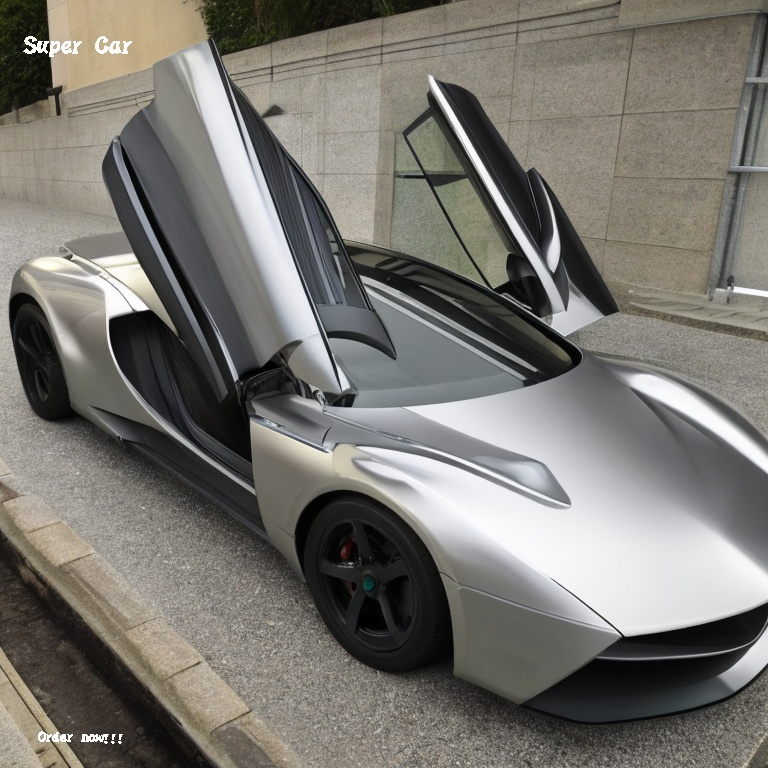

In [16]:
img = cv2.imread(img_path)
width, height = img.shape[1], img.shape[0]
img_size = (width, height)
# scaled_width_ratio, scaled_height_ratio = width / STD_WIDTH, height / STD_HEIGHT
smooth_region_mask, regions, saliency_map = smooth_region_dectection(img)
# regions là các hộp giới hạn xác định vùng mượt.
# saliency_map là Bản đồ nổi bật của ảnh
#
bbox_distrib_map = get_distrib_mask(smooth_region_mask)
#
# MASK NỔI BẬT CÁC KHU VỰC ĐƯỢC ỨNG CỬ CÓ THỂ CHỌN
cv2.imwrite("./qh_candidate_regions.jpg", smooth_region_mask[0] * 255)
#
# MẶT NẠ BIỂU DIỄN CỦA XÁC SUẤT XUẤT HIỆN CÁC KHU VỰC ỨNG CỬ TRONG smooth_region_mask
cv2.imwrite("./qh_layout_distribution.jpg", bbox_distrib_map * 255)
#
# show (salicy_map, smooth_region) in a figure.
saliency_map_with_smooth = np.zeros((height, width, 3))
saliency_map_with_smooth[:, :, 0] = saliency_map / saliency_map.max()
smooth_region_mask = cv2.resize(smooth_region_mask[0], (width, height))
saliency_map_with_smooth[:, :, 2] = smooth_region_mask / smooth_region_mask.max()
saliency_map_with_smooth = cv2.resize(saliency_map_with_smooth, (width, height))
#
# BẢN ĐỒ LÀM NỔI BẬT CÁC KHU VỰC ĐƯỢC ỨNG CỬ
cv2.imwrite("./qh_saliency_map_with-smooth.jpg", saliency_map_with_smooth * 255)
#
# show (salicy_map, predicted_layout_distribution) in a figure.
saliency_map_with_distrib = np.zeros((height, width, 3))
saliency_map_with_distrib[:, :, 0] = saliency_map / saliency_map.max()
bbox_distrib_map = cv2.resize(bbox_distrib_map, (width, height))
saliency_map_with_distrib[:, :, 2] = bbox_distrib_map / bbox_distrib_map.max()
saliency_map_with_distrib = cv2.resize(saliency_map_with_distrib, (width, height))
#
# BẢN ĐỒ LÀM NỔI BẬT VÙNG MỊN
cv2.imwrite("./qh_saliency_map_with-layout-distribution.jpg", saliency_map_with_distrib * 255)

from utils.font_utils import PutText2Image
from model.distrib_model import LayoutsDistribModel
from layout_distribution_predict import smooth_region_dectection, get_distrib_mask

    # A example of layout text.
    # sentences = [
    # ("Hello, World", 50),
    # ("POSTER", 35),
    # ("LAYOUT-LAYOUT", 35)]
# Khởi tạo danh sách rỗng
sentences = []
# Số lượng mục cần thêm
num_items = int(input("Nhập số lượng dòng: "))
# Nhập dữ liệu từ bàn phím
for _ in range(num_items):
    text_input = input("Nhập văn bản: ")
    number_input = int(input("Nhập kích thước chữ: "))
    # text_trans = translator(str(text_input))
    text_trans = (str(text_input))
    # Thêm vào danh sách
    sentences.append((text_trans, number_input))

print(sentences)

    # A example font file.
font_file = "/content/Text2Poster-ICASSP-22/font_files/test_font.TTF"
text_color = (255, 255 ,255)


    # The iteration round of layout refine model.
iteration_rounds = 30

ft_center = PutText2Image(font_file)
bbox_size_array = np.zeros((len(sentences), 2))

img = cv2.imread(img_path)
width, height = img.shape[1], img.shape[0]
img_size = (width, height)
data_len = len(sentences)

smooth_region_mask, regions, saliency_map = smooth_region_dectection(img)
bbox_distrib_map = get_distrib_mask(smooth_region_mask)

for i, text_info in enumerate(sentences):
  bbox_size_array[i] = ft_center.get_text_bbox_size(text=text_info[0], text_size=text_info[1])
    # initial layout, sampled by the maximum probability above the bbox_distrib_map.
initial_bboxes = get_batch_text_region(bbox_distrib_map, bbox_size_array, img_size)
print("initial_bboxes:", initial_bboxes.shape)
initial_bbox_mask = get_bbox_mask(initial_bboxes, data_len)

    # The data used to refine the layout.
initial_data = {"len_info": data_len,
             "shifted_mask": initial_bbox_mask.copy(),
             "shifted_bbox": initial_bboxes.copy(),
             "bbox_distrib_map": bbox_distrib_map.copy(),
             "smooth_region_mask": smooth_region_mask.copy()}

    # The refined layout.
refined_bboxes, refined_bbox_size, order = get_refine_bboxes(initial_data, iteration_rounds)
print("refine_bboxes:", refined_bboxes.shape)
refined_bbox_mask = get_bbox_mask(refined_bboxes[None, :], data_len)

    # scale the layout to the image size.
refined_bboxes[:, (0, 2)] = refined_bboxes[:, (0, 2)] / STD_WIDTH * width
refined_bboxes[:, (1, 3)] = refined_bboxes[:, (1, 3)] / STD_HEIGHT * height

    # show (salicy_map, predicted_layout_distribution, initial_layout) in a figure.
add_sal_mask = np.zeros((height, width, 3))
initial_bbox_mask = cv2.resize(initial_bbox_mask[0], (width, height))
smooth_region_mask = cv2.resize(smooth_region_mask[0], (width, height))
add_sal_mask[:, :, 2] = initial_bbox_mask / initial_bbox_mask.max()
bbox_distrib_map = cv2.resize(bbox_distrib_map, (width, height))
add_sal_mask[:, :, 1] = bbox_distrib_map / bbox_distrib_map.max()
add_sal_mask[:, :, 0] = saliency_map / saliency_map.max()
add_sal_mask = cv2.resize(add_sal_mask, (width, height))

#
# LAYOUT ĐƯỢC CHỌN NGẪU NHIÊN
cv2.imwrite("./qh_initial_layout.jpg", add_sal_mask * 255)

   # show (salicy_map, predicted_layout_distribution, refined_layout) in a figure.
add_sal_mask = np.zeros((height, width, 3))
refined_bbox_mask = cv2.resize(refined_bbox_mask[0], (width, height))
   # smooth_region_mask = cv2.resize(smooth_region_mask[0], (width, height))
add_sal_mask[:, :, 2] = refined_bbox_mask / refined_bbox_mask.max()
bbox_distrib_map = cv2.resize(bbox_distrib_map, (width, height))
add_sal_mask[:, :, 1] = bbox_distrib_map / bbox_distrib_map.max()
add_sal_mask[:, :, 0] = saliency_map / saliency_map.max()
add_sal_mask = cv2.resize(add_sal_mask, (width, height))

#
# LAYOUT CUỐI CÙNG SAU QUÁ TRÌNH TINH CHỈNH BỐ CỤC LẶP ĐI LẶP LẠI
cv2.imwrite("./qh_refined_layout.jpg", add_sal_mask * 255)

    # save the final poster picture.
bk_img = img.copy()
bk_img = bk_img.astype(np.uint8)
for j in range(len(sentences)):
    text_position = (refined_bboxes[j][0], refined_bboxes[j][1])
    text, text_size = sentences[order[j]][0], sentences[order[j]][1]
    bk_img = ft_center.draw_text(bk_img, text_position, text, text_size, text_color)


cv2.imwrite("./qh_poster.jpg", bk_img)

image_path = "./qh_poster.jpg"
image1 = Image.open(image_path)

display(image1)
#
# Nhập số lượng dòng: 2
# Nhập văn bản: Super Car
# Nhập kích thước chữ: 25
# Nhập văn bản: Order now!!!
# Nhập kích thước chữ: 15